In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

print(tf.__version__)
# tf.get_logger().setLevel('INFO')

import logging
tf.get_logger().setLevel(logging.ERROR)


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
model = keras.models.load_model('ML_model/ANN_model')

OSError: No file or directory found at ML_model/ANN_model

In [2]:
def inputsoutputsAllfiles(trainIterations, filepatharray, Timestepsize, maxtimestep):

    def xyz(iteration, filepath, Timestepsize, Timestep):

        # HACK FOR V2.0

        if (iteration == 0) & (Timestep == 1):
            x = np.zeros(1000)
            y = np.zeros(1000)
            z = np.zeros(1000)
        else:        
            Time = Timestep*Timestepsize 
            if Time%1 == 0:
                Time =int(Time)
            else: 
                Time = round(Time,2)
            my_file = open(filepath + str(Time) +"/solidsCellD_iteration"+str(iteration))
            string_list = my_file.readlines()
            index=18
            string_list = string_list[index+2:len(string_list)] 
            string_list = string_list[0:len(string_list)-4] 
            i=0
            for i in range(len(string_list)):
                string_list[i]=string_list[i].replace("(","")
                string_list[i]=string_list[i].replace(")","")
                string_list[i]=string_list[i].split()
            arr=np.array(string_list)
            arr= arr.astype(np.float64)
            x = arr[:,0]
            y = arr[:, 1]
            z = arr[:, 2]
        return x, y, z #, arr
        
      
    def maxIteration (Timestep, Timestepsize, filepath):
        Time = Timestep*Timestepsize
        Time = round(Time,2)   # Rounds to deicimal place
        file = filepath + "residual.dat"

        df = pd.read_csv(file)

        df.columns = ['One'] #Labels first Column

        df['One'] = df['One'].astype('string') # Converts to string

        new = df['One'].str.split(' ', expand = True) #splits into new dataframe on spaces

        df['TimeStep']= new[0].astype('float')  # labels new columns and inserts in dataframe
        df['solverPerfInitRes']= new[1].astype('float')  # labels new columns and inserts in dataframe
        df['residualvf']= new[2].astype('float')  # labels new columns and inserts in dataframe
        df['materialResidual']= new[3].astype('float')  # labels new columns and inserts in dataframe
        df["IterationNumber"]= new[4].astype('float') # labels new columns and inserts in dataframe

        df.drop(columns =['One'], inplace = True) #Removes original column

        array = np.array
        array = []

        for i in range(len(df)):        #loops through residual file

            if df['TimeStep'][i] == Time:   # Finds values for a timestep
                x = df['IterationNumber'][i]
                array.append(x)            # Creates arrays of iteration numbers
                
        max = np.max(array) # returns max of array
        max=int(max)
        return max
    
    def inputsoutputsAllTimesteps(trainIterations, filepath, Timestepsize):

        def inputsoutputsTimestep(trainIterations, filepath, Timestepsize, Timestep):

            max = maxIteration(Timestep, Timestepsize, filepath)

            x,y,z = xyz(1, filepath, Timestepsize, Timestep)
            matrix = np.array(np.vstack((x,y,z))) #Gives matrix a starting value which is removed later

            for i in range(0,trainIterations): # loops for each iteration up to trainIteration
                x,y,z = xyz(i,filepath, Timestepsize, Timestep)
                arr = np.vstack((x,y,z))  # gives array with x, y, z values for each iteration
                matrix = np.concatenate((matrix, arr))   # combines arrays

            inputs = matrix[3:,:] # removes initial value

            xmax, ymax, zmax = xyz(max, filepath, Timestepsize, Timestep)
            outputs = np.vstack((xmax,ymax,zmax)) # array of values at max iteration

            inputs = np.transpose(inputs)  # multiple columns : (x1, y1, z1, x2, y2, z2 ...)
            outputs = np.transpose(outputs)

            return inputs, outputs

        arrinputs = np.ones((1, trainIterations*3)) # first row to be removed after
        arroutputs = np.ones((1, 3))

        #combines inputs and outputs of all timesteps

        for Timestep in range(1,maxtimestep+1):
            inputs, outputs = inputsoutputsTimestep(trainIterations, filepath, Timestepsize, Timestep)
            arrinputs = np.vstack((arrinputs,inputs))
            arroutputs = np.vstack((arroutputs,outputs))

        arrinputs = arrinputs[1:,:] #removes oriinal row of ones
        arroutputs = arroutputs[1:,:]#removes oriinal row of ones

        outputs = arroutputs
        inputs = arrinputs

        return inputs, outputs   # Returns the inputs and outputs of Alltimesteps for one file

    arrinputs = np.ones((1, trainIterations*3))
    arroutputs = np.ones((1, 3))

    for i in range(0,len(filepatharray),1):
        inputs, outputs = inputsoutputsAllTimesteps(trainIterations, filepatharray[i], Timestepsize)
        arrinputs = np.vstack((arrinputs,inputs))
        arroutputs = np.vstack((arroutputs,outputs))

    arrinputs = arrinputs[1:,:] #removes oriinal row of ones
    arroutputs = arroutputs[1:,:]#removes oriinal row of ones

    outputs = arroutputs
    inputs = arrinputs

    return inputs, outputs

In [3]:
filepath1 = "../mesh10/plateHole/"

filepatharray = [filepath1]

In [4]:
trainIterations = input("Enter your training iteration value: ")
trainIterations = int(trainIterations)

Timestepsize = 1
maxtimestep = 10

inputs, outputs = inputsoutputsAllfiles(trainIterations, filepatharray, Timestepsize, maxtimestep)

In [6]:
# define model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

X = inputs
y = outputs

scalerI = StandardScaler().fit(X) #FitScaler
scalerO = StandardScaler().fit(y)


scaledX = scalerI.transform(X) # Scale X
scaledY = scalerO.transform(y)

In [7]:
# Ask for number of epocs

# answer_epochs = input("Number of epochs?: ")
# answer_epochs = int(answer_epochs)

answer_epochs = 500

In [8]:
# Ask if solidProperties is ready

# answer_solidsProp = input("Is solidProperties ready?: (y/n)")

answer_solidsProp = "y"

In [8]:
# Ask to train or load model

# answer_trainOrLoadModel = input("Train or load model?: (t/l) ")

answer_trainOrLoadModel = "l"

2022-11-15 03:26:00.705419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-15 03:26:00.712934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 03:26:00.713092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-15 03:26:00.713175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-15 03:26:00.713252: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/500
313/313 [==============================] - 2s 4ms/step - loss: 0.0171
Epoch 2/500
313/313 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 3/500
313/313 [==============================] - 1s 5ms/step - loss: 4.1395e-04
Epoch 4/500
313/313 [==============================] - 1s 4ms/step - loss: 2.2647e-04
Epoch 5/500
313/313 [==============================] - 1s 5ms/step - loss: 5.9383e-04
Epoch 6/500
313/313 [==============================] - 1s 4ms/step - loss: 4.5040e-04
Epoch 7/500
313/313 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 8/500
313/313 [==============================] - 1s 4ms/step - loss: 3.0828e-04
Epoch 9/500
313/313 [==============================] - 1s 3ms/step - loss: 2.1514e-04
Epoch 10/500
313/313 [==============================] - 1s 3ms/step - loss: 1.3959e-04
Epoch 11/500
313/313 [==============================] - 1s 3ms/step - loss: 2.6666e-04
Epoch 12/500
313/313 [==============================] - 1s 3ms/s

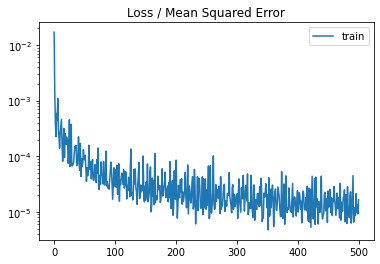

INFO:tensorflow:Assets written to: ML_model/ANN_model/assets


In [9]:

if answer_trainOrLoadModel == ("t"):

    model = Sequential()
    model.add(Dense(200, input_dim=len(X[0,:]), 
                    activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(150, 
                    activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(50, 
                    activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3))

    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit model
    history = model.fit(scaledX, scaledY, epochs=answer_epochs, verbose=1)


    # evaluate the model
    train_mse = model.evaluate(scaledX, scaledY, verbose=0)


    print('Train MSE: %f' % (train_mse))

    # plot loss during training
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.yscale('log')
    # plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    model.save('ML_model/ANN_model')

elif answer_trainOrLoadModel == ("l"):
    model = keras.models.load_model('ANN_model')


In [10]:
scaledPrediction = model.predict(scaledX)
prediction = scalerO.inverse_transform(scaledPrediction)

313/313 [==============================] - 1s 2ms/step


In [9]:

mean = np.hstack((scalerI.mean_, scalerO.mean_))
std = np.hstack((scalerI.scale_, scalerO.scale_))

names = np.array([])
for i in np.arange(1,len(mean)/3):

    names = np.append(
                        names, 
                        [
                            "X"+str(int(i)),
                            "Y"+str(int(i)),
                            "Z"+str(int(i))
                        ]      
                    )
names = np.append(
                    names,
                    [
                        "X_ouptut",
                        "Y_output",
                        "Z_output"
                    ]
                )

df = pd.DataFrame(data = np.vstack((mean, std)), columns = names, index = ["mean", "std"])

df

df.to_csv("ML_model/" + 'scalingData.csv')

In [15]:
#  Create mean and std strings
mean_string = str()
for i in np.arange(0,len(mean)/3):

    mean_string =  mean_string + "\t\t(" + str(mean[3*int(i)]) + "\t\t"+ str(mean[3*int(i) + 1]) + "\t\t"+ str(mean[3*int(i) + 2])+ ")\n"

std_string = str()
for i in np.arange(0,len(std)/3):

    std_string =  std_string + "\t\t(" + str(std[3*int(i)]) + "\t\t"+ str(std[3*int(i) + 1]) + "\t\t"+ str(std[3*int(i) + 2])+ ")\n"


In [21]:
# Save

import pickle
pickle.dump(scalerI, open('ML_model/scalerI.pkl','wb'))
pickle.dump(scalerO, open('ML_model/scalerO.pkl','wb'))


In [19]:
# Write traning iterations

def stringWrite2 (filename, string_find, string_insert):
    f = open(filename, "r")
    lines = f.readlines()
    f.close()

    index = 0
    for line in lines:
        index += 1 

        if string_find in line:
            break

    lines[index -1] = "\t" + string_find1 + " " +  string_insert1 + "; \n" 
    
    f = open(filename, "w")
    f.writelines(lines)
    f.close()

filename = "ML_model/solidProperties"

string_find1 = 'iterationToApplyMachineLearningPredictor'

string_insert1 = str(trainIterations)

if answer_solidsProp == "y":

    stringWrite2(filename, string_find1, string_insert1)

In [15]:
# Save Model

model.save('ML_model/fdeepTrial.h5', include_optimizer=False)

In [16]:
 #Save Data

 namesData = np.append(names, ["X_prediction", "Y_prediction", "Z_prediction"])
 
 df = pd.DataFrame(data = np.hstack((inputs, outputs, prediction)), index=None, columns = namesData)
 
 df.to_csv("ML_model/" + 'data.csv')

 df
 

,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,...,Z19,X20,Y20,Z20,X_ouptut,Y_output,Z_output,X_prediction,Y_prediction,Z_prediction
0,0.000000,0.000000,0.0,1.714870e-07,0.000000,0.0,2.484790e-07,-1.714940e-08,0.0,2.972270e-07,...,0.0,4.710580e-07,-1.672040e-07,0.0,5.325040e-07,-2.349030e-07,0.0,5.196176e-07,-2.327784e-07,-0.000024
1,0.000000,0.000000,0.0,1.730310e-07,0.000000,0.0,2.472850e-07,-1.906120e-08,0.0,2.933350e-07,...,0.0,4.473650e-07,-1.570260e-07,0.0,5.014410e-07,-2.181080e-07,0.0,4.898978e-07,-2.176803e-07,-0.000025
2,0.000000,0.000000,0.0,1.757440e-07,0.000000,0.0,2.485310e-07,-2.140020e-08,0.0,2.928850e-07,...,0.0,4.327710e-07,-1.511860e-07,0.0,4.814030e-07,-2.072410e-07,0.0,4.685656e-07,-2.084510e-07,-0.000025
3,0.000000,0.000000,0.0,1.794040e-07,0.000000,0.0,2.515950e-07,-2.398260e-08,0.0,2.950070e-07,...,0.0,4.248880e-07,-1.493630e-07,0.0,4.697150e-07,-2.018900e-07,0.0,4.573347e-07,-2.041546e-07,-0.000025
4,0.000000,0.000000,0.0,1.838480e-07,0.000000,0.0,2.560330e-07,-2.679580e-08,0.0,2.990140e-07,...,0.0,4.218030e-07,-1.499440e-07,0.0,4.637540e-07,-1.996630e-07,0.0,4.543181e-07,-2.033442e-07,-0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000001,-0.000005,0.0,1.409800e-06,-0.000005,0.0,1.427130e-06,-5.469290e-06,0.0,1.436310e-06,...,0.0,1.415550e-06,-5.728360e-06,0.0,1.387200e-06,-5.804360e-06,0.0,1.386501e-06,-5.814265e-06,0.000023
9996,0.000002,-0.000005,0.0,1.679240e-06,-0.000005,0.0,1.700050e-06,-5.373450e-06,0.0,1.711190e-06,...,0.0,1.688680e-06,-5.625430e-06,0.0,1.655750e-06,-5.697830e-06,0.0,1.655610e-06,-5.706657e-06,0.000029
9997,0.000002,-0.000005,0.0,1.953910e-06,-0.000005,0.0,1.978300e-06,-5.266550e-06,0.0,1.991490e-06,...,0.0,1.968160e-06,-5.510750e-06,0.0,1.930890e-06,-5.579010e-06,0.0,1.930781e-06,-5.586605e-06,0.000034
9998,0.000002,-0.000005,0.0,2.234150e-06,-0.000005,0.0,2.262180e-06,-5.150180e-06,0.0,2.277500e-06,...,0.0,2.254260e-06,-5.386040e-06,0.0,2.212950e-06,-5.449630e-06,0.0,2.214578e-06,-5.456403e-06,0.000039


In [17]:
 #Save Scaled Data

 namesData = np.append(names, ["X_prediction", "Y_prediction", "Z_prediction"])
 
 df = pd.DataFrame(data = np.hstack((scaledX, scaledY, scaledPrediction)), index=None, columns = namesData)
 
 df.to_csv("ML_model/" + 'dataScaled.csv')

 df

,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,...,Z19,X20,Y20,Z20,X_ouptut,Y_output,Z_output,X_prediction,Y_prediction,Z_prediction
0,-1.150154,0.954886,0.0,-1.125626,0.985948,0.0,-1.113523,1.000294,0.0,-1.105340,...,0.0,-1.058677,0.925685,0.0,-1.037605,0.873796,0.0,-1.042369,0.875447,-0.000024
1,-1.150154,0.954886,0.0,-1.125036,0.985948,0.0,-1.113976,0.998710,0.0,-1.106810,...,0.0,-1.067491,0.933744,0.0,-1.049088,0.886851,0.0,-1.053355,0.887183,-0.000025
2,-1.150154,0.954886,0.0,-1.124000,0.985948,0.0,-1.113503,0.996773,0.0,-1.106980,...,0.0,-1.072920,0.938368,0.0,-1.056495,0.895298,0.0,-1.061240,0.894358,-0.000025
3,-1.150154,0.954886,0.0,-1.122602,0.985948,0.0,-1.112341,0.994633,0.0,-1.106178,...,0.0,-1.075853,0.939812,0.0,-1.060815,0.899458,0.0,-1.065392,0.897697,-0.000025
4,-1.150154,0.954886,0.0,-1.120905,0.985948,0.0,-1.110656,0.992302,0.0,-1.104664,...,0.0,-1.077001,0.939352,0.0,-1.063019,0.901189,0.0,-1.066507,0.898327,-0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.620887,-3.531365,0.0,-0.652697,-3.515872,0.0,-0.666212,-3.516810,0.0,-0.674884,...,0.0,-0.707307,-3.477606,0.0,-0.721662,-3.455576,0.0,-0.721920,-3.463275,0.000023
9996,-0.519841,-3.449024,0.0,-0.549794,-3.435635,0.0,-0.562636,-3.437406,0.0,-0.571008,...,0.0,-0.605697,-3.396107,0.0,-0.622391,-3.372766,0.0,-0.622442,-3.379627,0.000029
9997,-0.416871,-3.357194,0.0,-0.444894,-3.346126,0.0,-0.457037,-3.348840,0.0,-0.465084,...,0.0,-0.501725,-3.305304,0.0,-0.520684,-3.280402,0.0,-0.520724,-3.286306,0.000034
9998,-0.311881,-3.257188,0.0,-0.337866,-3.248661,0.0,-0.349301,-3.252427,0.0,-0.357002,...,0.0,-0.395290,-3.206559,0.0,-0.416419,-3.179830,0.0,-0.415817,-3.185094,0.000039


10000

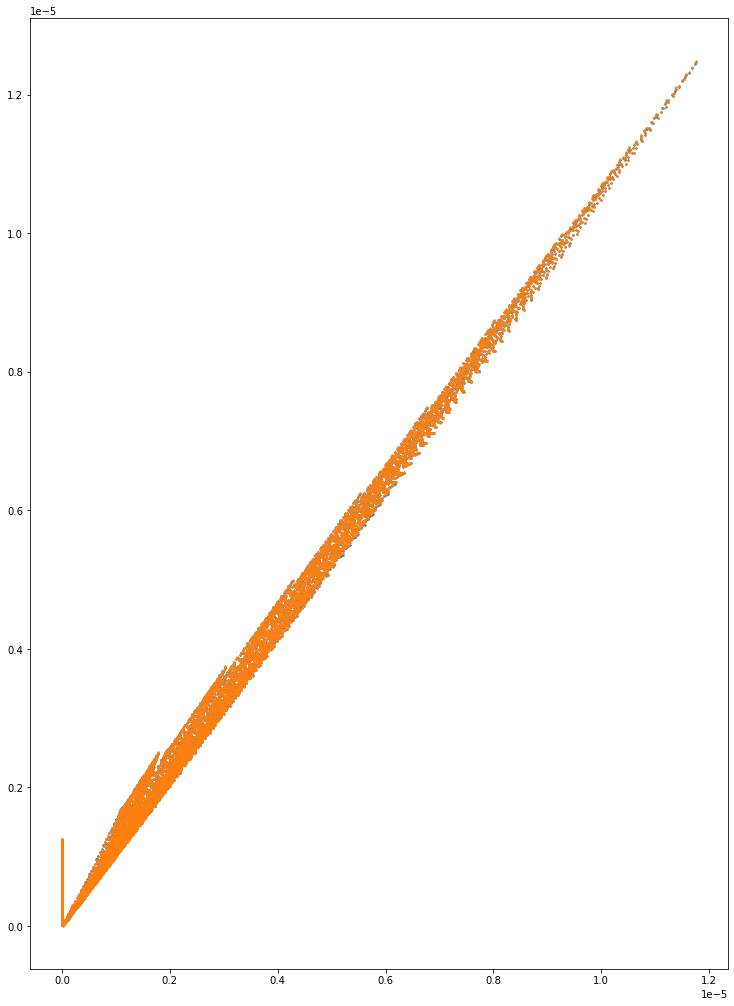

In [18]:
f=15

fig = plt.figure(figsize=(12.5, 17.5))
plt.scatter(inputs[:,0],outputs[:,0], s= 2)
plt.scatter(inputs[:,0],prediction[:,0],s = 2)
len(inputs[:,0])



## END FOR NOW